# Runs of the transformer model with the new preprocessing scheme and a dropout layer.
## On Hebrew only.

In [1]:
from pandas import read_csv

scores = read_csv('tfr-nph.csv', sep='\t')
scores.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 16 columns):
job          287 non-null int64
seqlen       287 non-null int64
epochs       287 non-null int64
lrate        287 non-null float64
dropout      287 non-null float64
times        287 non-null object
f_in         287 non-null object
f_out        287 non-null object
embsize      287 non-null int64
n_heads      287 non-null int64
n_enc        287 non-null int64
n_dec        287 non-null int64
network      287 non-null object
batchsize    287 non-null int64
complete     287 non-null float64
distinct     287 non-null object
dtypes: float64(3), int64(8), object(5)
memory usage: 36.0+ KB


In [2]:
scores

,job,seqlen,epochs,lrate,dropout,times,f_in,f_out,embsize,n_heads,n_enc,n_dec,network,batchsize,complete,distinct
0,5103,7,20,0.000153,0.050,"(""17:10:14"", ""19:07:02"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.717751,"[0.9485629754860524, 0.951141166525782, 0.9492..."
1,5104,7,20,0.000153,0.100,"(""17:10:13"", ""19:01:33"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.552156,"[0.9060016906170753, 0.9095519864750634, 0.909..."
2,5105,7,20,0.000153,0.150,"(""17:10:13"", ""19:02:55"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.725613,"[0.9498309382924768, 0.9498732037193576, 0.949..."
3,5106,7,20,0.000153,0.200,"(""17:10:19"", ""19:01:06"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.705959,"[0.9442096365173288, 0.947295012679628, 0.9462..."
4,5107,7,20,0.000153,0.250,"(""17:10:20"", ""19:02:52"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.687658,"[0.9398562975486052, 0.9430684699915469, 0.940..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
282,6618,9,80,0.000272,0.150,"(""09:43:48"", ""13:54:28"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.762674,"[0.9650103403946119, 0.9688111340897658, 0.966..."
283,6619,7,80,0.000276,0.145,"(""09:44:16"", ""14:14:48"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.803212,"[0.96458157227388, 0.9658072696534235, 0.96614..."
284,6620,9,80,0.000276,0.145,"(""09:44:17"", ""13:57:15"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.770555,"[0.9666312671175451, 0.9690347101894807, 0.968..."
285,6621,7,80,0.000280,0.140,"(""09:44:34"", ""14:13:27"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.801310,"[0.9635672020287405, 0.967032967032967, 0.9662..."


In [3]:
# Add a column with the highest score on the distinct words.
scores['wordscore'] = scores['distinct'].apply(eval).apply(max)

# And a column with the position of the word with the highest score.
# Let us number the words from 1 on.
from numpy import argmax

def argmax1(x):
    return argmax(x) + 1

scores['position'] = scores['distinct'].apply(eval).apply(argmax1)

## We will vary the parameters 'lrate' and 'dropout'.

Investigating the varied parameters, we want the other parameters to remain the same. For the parameters in the dataset whose columns are univalent, this is automatically the case. If there are also parameters (apart from the varied parameters) with multivalent columns, we choose the combination with the highest frequency.

In [4]:
Parameters = ['seqlen', 'epochs', 'lrate', 'dropout', 'embsize',
   'n_heads', 'n_enc', 'n_dec', 'batchsize']

Varied = ['lrate', 'dropout']

# The function get_constants() returns a dictionary with the
# multivalent parameters and the values at which they are to
# be kept constant during the selection of data points.

def get_constants(scores, varied):
    cols = []
    for p in Parameters:
        if p not in varied and len(scores[p].unique()) > 1:
            cols.append(p)
    if not cols:
        return {}
    else:
        modes = scores[cols].apply(tuple, 1).mode()[0]
        return dict(zip(cols, modes))

params = get_constants(scores, Varied)

selection = scores['job'].notna()
for p in params:
    selection &= scores[p] == params[p]
print(f'Subselection on constant parameters {params}.')

Subselection on constant parameters {'seqlen': 7, 'epochs': 20}.


In [5]:
# Make a sorted dataframe of the selection.
df = scores[selection].sort_values(Varied)
print(f'Selection comprises {len(df)} entries.')

Selection comprises 257 entries.


In [6]:
# Choose the target we want to investigate.
# This can be either 'complete' or 'wordscore'.
target = 'complete'
target = 'wordscore'

In [7]:
# Create the x, y, and z vectors of the data we want to plot.
from numpy import array

x = array(list(df[Varied[0]]))
y = array(list(df[Varied[1]]))
z = array(list(df[target]))

# Store the coordinates of the highest data point.
i = argmax(z)
x_max, y_max = (x[i], y[i])
z_max, z_min = (max(z), min(z))

In [8]:
# Prepare the mesh of the graph.
from numpy import linspace
from matplotlib.pyplot import rcParams, xticks

# Lower and upper x and y in the graph.
lx, ux = (min(x), max(x))
ly, uy = (min(y), max(y))

# General graph parameters.
aspect = 3/4
width = 12
rcParams['figure.figsize'] = [width, aspect * width]
plParams = dict(cmap='plasma', vmin=z_min, vmax=z_max)

def x_axis(x):
    x_lo = round(lx, 4)
    x_hi = round(ux, 4)
    t = linspace(x_lo, x_hi, round((x_hi-x_lo)*1e4)+1)
    xticks(t, [f'{round(z*1e4,1)}' for z in t])

# We tile the graph with a colour mesh of kx * ky tiles.
kx = 100
ky = aspect * kx

# Each tile {(x,y), (x+dx,y+dy)} is coloured with the value
# f(x+dx/2,y+dy/2).
x_corners = linspace(lx, ux, kx+1)
y_corners = linspace(ly, uy, ky+1)

x_centres = x_corners[:-1] + (ux - lx) / kx
y_centres = y_corners[:-1] + (uy - ly) / ky

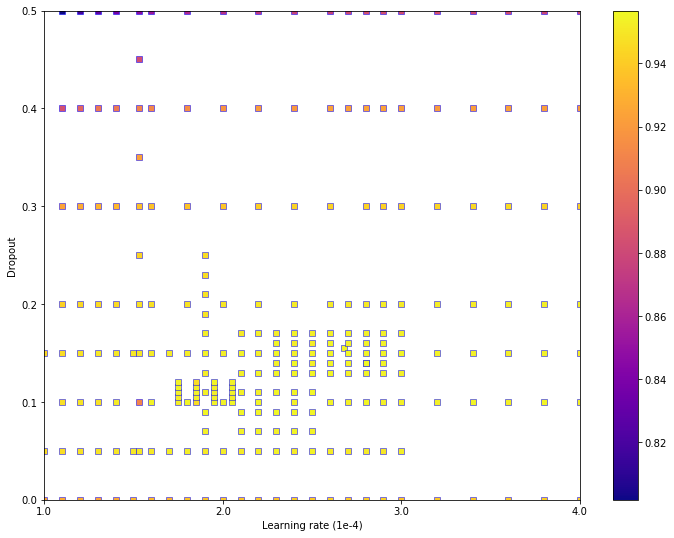

In [9]:
# Make a scatter plot of the data points for a first impression.
from matplotlib.pyplot import xlim, ylim, scatter, xlabel, ylabel,\
   colorbar, show
xlim(lx, ux)
ylim(ly, uy)
scatter(x, y, c=z, marker='s', edgecolor='b', lw=1/2, **plParams)
x_axis(x)
xlabel('Learning rate (1e-4)')
ylabel('Dropout')
colorbar()
show()

The scatter plot of the data points does not reveal much, so let us make a smoothed interpolation with contour lines in the hope that we can spot some global tendencies.

Contour lines at ['0.900', '0.918', '0.933', '0.944', '0.951', '0.955']
Best run: 0.957 for lrate=2.80e-04 and dropout=0.140
Projected maximum: 0.955 for lrate=2.68e-04 and dropout=0.160


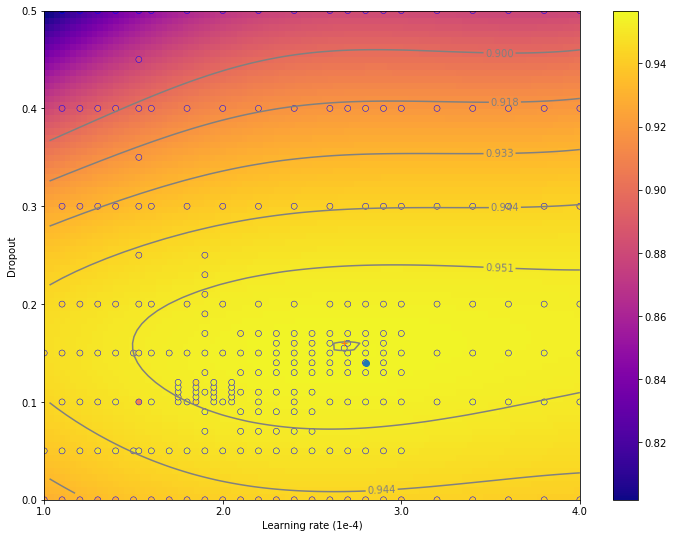

In [10]:
# Create a bivariate spline and plot it with contour lines.
from numpy import floor, unravel_index
from matplotlib.pyplot import contour, clabel, pcolormesh, plot
from scipy.interpolate import SmoothBivariateSpline

sbs = SmoothBivariateSpline(x, y, z)
zs = sbs(x_centres, y_centres)

# Calculate the levels at which to show the contour lines.
cm = floor(1000*z_max-1)/1000
n = 6
m = 2 * n * (n + 1) / (z_max - z_min)
levels = sorted([cm-i*(i+1)/m for i in range(n)])
print('Contour lines at', [f'{x:.3f}' for x in levels])

# Plot the contour lines.
xlim(lx, ux)
ylim(ly, uy)
clabel(contour(x_centres, y_centres, zs.T, levels=levels, colors='grey'))

# Plot the bivariate spline.
pcolormesh(x_corners, y_corners, zs.T, shading='flat', **plParams)

# Add the data points.
scatter(x, y, c=z, edgecolor='b', lw=1/2, **plParams)

# Plot the position of the best run.
maxs = (z_max, x_max, y_max)
print('Best run: %.3f for lrate=%.2e and dropout=%.3f' % maxs)
plot(x_max, y_max, 'o')

# Plot the position of the projected maximum.
x_max, y_max = unravel_index(argmax(zs), zs.shape)
maxs = (zs[x_max, y_max], x_centres[x_max], y_centres[y_max])
print('Projected maximum: %.3f for lrate=%.2e and dropout=%.3f' % maxs)
plot(x_centres[x_max], y_centres[y_max], '+')

x_axis(x)
xlabel('Learning rate (1e-4)')
ylabel('Dropout')
colorbar()
show()

## What does the cross section along a dropout of 0.15 look like?

Most data points for dropout = 0.15.
Maximum in data for lrate = 2.70e-04.
Projected maximum for lrate = 2.68e-04.


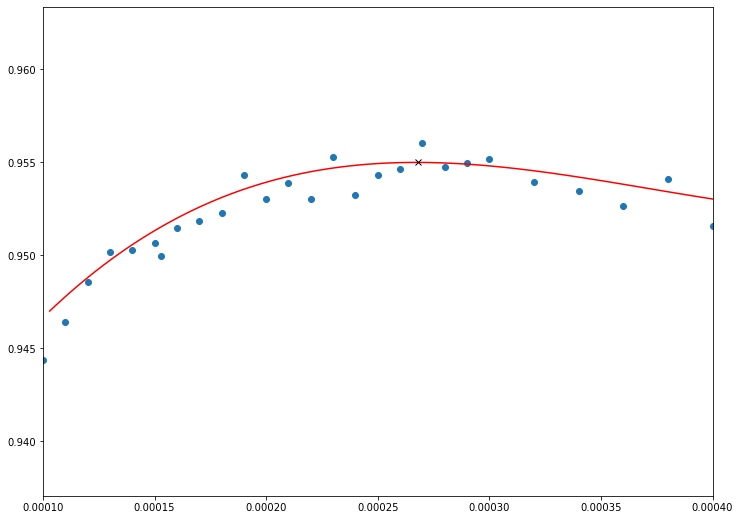

In [11]:
v = scores[Varied[1]].mode()[0]
print(f'Most data points for {Varied[1]} = {v}.')

dd = df[(df[Varied[1]]==v)]

scatter(dd[Varied[0]], dd[target])

xlim(lx, ux)
yd = sbs(x_centres, v)
i = argmax(yd)
plot(x_centres, yd, 'r')
plot(x_centres[i], yd[i], 'x', color='black')
m = dd[Varied[0]][dd[target].idxmax()]
print(f'Maximum in data for {Varied[0]} = {m:.2e}.')
print(f'Projected maximum for {Varied[0]} = {x_centres[i]:.2e}.')

## In which position is the word predicted best?

Word 2 is predicted best.


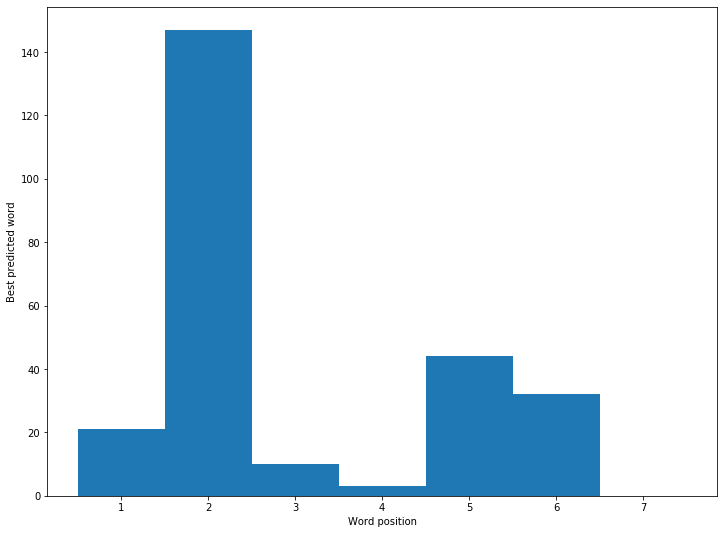

In [12]:
from matplotlib.pyplot import hist, step

xlabel('Word position')
ylabel('Best predicted word')

# Apply a continuity correction to the range
seqlen = df['seqlen'][0]
r = [x - 1/2 for x in (1, seqlen+1)]
df['position'].hist(bins=seqlen, grid=False, range=r)
print('Word %d is predicted best.' % df['position'].mode())

# Let us make a new selection so that we can look at the influence of the sequence lenght.

In [13]:
Varied = ['seqlen']

params = get_constants(scores, Varied)
selection = scores['job'].notna()
for p in params:
    selection &= scores[p] == params[p]
print(f'Subselection on constant parameters {params}.')

# We keep the last, that is, the best score.
df = scores[selection].sort_values(Varied + [target]).drop_duplicates(Varied, keep='last')
df

Subselection on constant parameters {'epochs': 20.0, 'lrate': 0.00028, 'dropout': 0.14}.


,job,seqlen,epochs,lrate,dropout,times,f_in,f_out,embsize,n_heads,n_enc,n_dec,network,batchsize,complete,distinct,wordscore,position
256,6176,1,20,0.00028,0.14,"(""10:08:49"", ""10:51:47"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.929712,[0.9297119599248591],0.929712,1
257,6177,2,20,0.00028,0.14,"(""10:08:52"", ""11:15:25"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.894705,"[0.9454160171473109, 0.9439058846453624]",0.945416,1
258,6178,3,20,0.00028,0.14,"(""10:08:53"", ""11:33:58"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.864141,"[0.9503419168714606, 0.952585746340421, 0.9483...",0.952586,2
259,6179,4,20,0.00028,0.14,"(""10:08:52"", ""11:44:43"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.822725,"[0.9470390269823463, 0.9521461888173821, 0.950...",0.952146,2
260,6180,5,20,0.00028,0.14,"(""10:08:56"", ""11:53:41"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.804530,"[0.95272894858121, 0.9540786095200474, 0.95509...",0.955099,3
261,6181,6,20,0.00028,0.14,"(""10:08:55"", ""11:58:28"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.767444,"[0.9515662114014252, 0.9544239904988123, 0.953...",0.954424,2
217,6182,7,20,0.00028,0.14,"(""10:08:55"", ""12:02:06"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.743026,"[0.9532121724429417, 0.9567624683009298, 0.954...",0.956762,2
262,6183,8,20,0.00028,0.14,"(""10:08:58"", ""11:58:19"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.719203,"[0.953022737189121, 0.9546710622000291, 0.9541...",0.954671,2
263,6184,9,20,0.00028,0.14,"(""10:09:00"", ""11:55:47"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.692471,"[0.95316080710972, 0.9569616008048739, 0.95506...",0.956962,2
264,6185,10,20,0.00028,0.14,"(""10:08:59"", ""11:49:44"")",t-in_voc,t-out,512,8,3,3,transformer,128,0.656541,"[0.9500647668393782, 0.9545984455958549, 0.952...",0.954598,2


Maximum of 0.957 for a sequence of 9 words in 20 epochs at a learning rate of 2.80e-04 with a dropout of 0.14.
Maximum was found at word position 2.


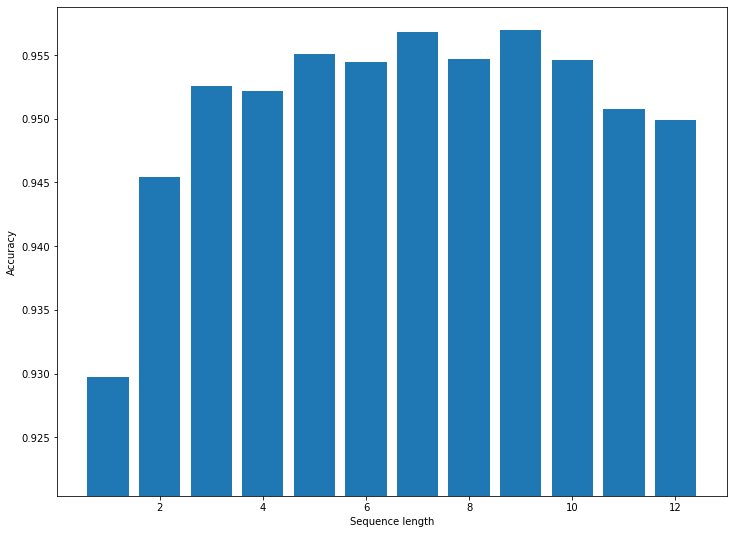

In [14]:
# Create a scatter plot of the values
from matplotlib.pyplot import bar

xlabel('Sequence length')
ylabel('Accuracy')

# The y-range [0:dy] is left out of the graph.
dy = df[df['seqlen']==df['seqlen'].min()][target].values[0] * 0.99
bar(df['seqlen'], df[target]-dy, bottom=dy)

m = df.loc[df[target].idxmax()]
maxs = (m[target], m['seqlen'], m['epochs'], m['lrate'], m['dropout'])
print('Maximum of %.3f for a sequence of %d words in %d epochs'
      ' at a learning rate of %.2e with a dropout of %.2f.' % maxs)
print('Maximum was found at word position %d.' % m['position'])

Odd sequence lenghts seem to be slightly favoured.

# What is the best run among all of the data?

In [15]:
m = scores.loc[scores[target].idxmax()]
maxs = (m[target], m['seqlen'], m['epochs'], m['lrate'], m['dropout'])
print('Maximum of %.3f for a sequence of %d words in %d epochs'
      ' at a learning rate of %.2e with a dropout of %.3f.' % maxs)
print('Maximum was found at word position %d.' % m['position'])

Maximum of 0.970 for a sequence of 9 words in 80 epochs at a learning rate of 2.68e-04 with a dropout of 0.155.
Maximum was found at word position 5.


# What is the average runtime of the runs?

In [16]:
# Benchmark: seqlen == 9 && epochs == 20.

from datetime import datetime

def time(s):
    fmt = '%H:%M:%S'
    return datetime.strptime(s, fmt)

def runtime(s):
    start, stop = eval(s)
    return (time(stop) - time(start)).seconds

selection = (scores['seqlen'] == 9) & (scores['epochs'] == 20)
dt = scores[selection]['times'].apply(runtime).mean()
print(f'Average runtime = {dt/60:.0f} minutes.')

Average runtime = 106 minutes.
